In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import Sequence, Tuple
import pandas as pd
from sklearn.datasets import fetch_openml
from collections import OrderedDict, defaultdict
import torch.nn.functional as F
model_equations = []

def fed_model(testimages):
    wine = fetch_openml(name='wine-quality-red', version=1, as_frame=True, parser='liac-arff')
    X = wine.data
    y = wine.target
    y = wine.target.astype(int)
    def adjust_target(value):
        if value == 3:
            return 0
        elif value == 9:
            return 6
        else:
            return value - 3
    y = y.apply(adjust_target)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train = y_train.astype(int)
    y_train_np = y_train.to_numpy().astype(int)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test = y_test.astype(int)
    y_test_np = y_test.to_numpy()
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    n_clients = 3

    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, n_clients)

    client_loaders = []
    batch_size = 16
    for client_indices in split_indices:
        client_subset = Subset(train_dataset, client_indices)
        client_loader = DataLoader(client_subset, batch_size=batch_size, shuffle=True)
        client_loaders.append(client_loader)

    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(11, 50)
            self.fc2 = nn.Linear(50, 20)
            self.fc3 = nn.Linear(20, 6)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    client_models = []
    epochs = 20
    criterion = nn.CrossEntropyLoss()

    for i, loader in enumerate(client_loaders):
        model = SimpleNN()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        torch.save(model.state_dict(), f'client_{i+1}_model.pth')
        client_models.append(model.state_dict())
        sums = defaultdict(int)
        count = len(client_models)
        for od in client_models:
            for key, value in od.items():
                sums[key] += value

        averages = {key: value / count for key, value in sums.items()}
        average_ordereddict = OrderedDict(averages)

        model.load_state_dict(average_ordereddict)
        testimages = torch.tensor(testimages, dtype=torch.float32)
        y_test = model(testimages)
        return y_test
class Config:
    def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

class Model(nn.Module):
    def __init__(self, config, name):
        super(Model, self).__init__()
        self.config = config
        self.name = name
class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.input_shape = input_shape
        self.num_units = num_units
        self.feature_num = feature_num
        self.fc = nn.Linear(input_shape, num_units)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        return x

class NAM(Model):
    def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
        super(NAM, self).__init__(config, name)
        self._num_inputs = num_inputs
        self.dropout = nn.Dropout(p=self.config.dropout)

        if isinstance(num_units, list):
            assert len(num_units) == num_inputs
            self._num_units = num_units
        elif isinstance(num_units, int):
            self._num_units = [num_units for _ in range(self._num_inputs)]

        self.feature_nns = nn.ModuleList([
            FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
            for i in range(num_inputs)
        ])

        self.output_layer = nn.Linear(sum(self._num_units), 3)
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs: torch.Tensor) -> Sequence[torch.Tensor]:
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self._num_inputs)]

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout(conc_out)
        out = self.output_layer(dropout_out)
        return out, dropout_out

    def print_model_equation(self, feature_names):
        equation_terms = []
        feature_contributions = {}
        print("feature_names")
        print(feature_names)
        for i, fnn in enumerate(self.feature_nns):
            coefficients = fnn.fc.weight.data.flatten().tolist()
            intercepts = fnn.fc.bias.data.tolist()
            term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
            equation_terms.append(term)
            feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
        equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
        print(f"Model Equation: y = {equation}")
        model_equations.append(equation)
        interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        print("\nFeature Contributions:")
        for feature, contribution in interpretability:
            print(f"{feature}: {contribution:.3f}")

        return interpretability[0][0],interpretability[-1][0]   # Return the feature with the highest contribution

n_clients = 3
data = fetch_openml(name='wine-quality-red', version=1, as_frame=True, parser='liac-arff')
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
client_data = [df.iloc[i * len(df) // n_clients: (i + 1) * len(df) // n_clients] for i in range(n_clients)]
clients_features = [client.drop(columns=['target']) for client in client_data]
clients_targets = [client['target'] for client in client_data]
clients_targets = [target.astype(int) for target in clients_targets]
clients_features = [client.drop(columns=['target']) for client in client_data]

clients_features1 = {}
clients_features2 = {}
for i in range(n_clients):
    feature_columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

    df = clients_features[i].head()

    def adjust_target(value):
        return value - 3

    target = clients_targets[i].head()
    X = df[feature_columns].values
    y = target
    y = target.apply(adjust_target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train = y_train.astype(int)
    y_train_np = y_train.to_numpy().astype(int)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test = y_test.astype(int)
    y_test_np = y_test.to_numpy()
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)
    config = Config(dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32)
    num_inputs = len(feature_columns)  # Number of features
    num_units = 10  # Number of units in the hidden layer
    nam_model = NAM(config=config, name='NAM_Model', num_inputs=num_inputs, num_units=num_units)
    def train(model, X_train, y_train, config):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        model.train()
        for epoch in range(config.num_epochs):
            outputs = fed_model(X_test_tensor)
            optimizer.zero_grad()
            y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
            loss = criterion(outputs, y_test_tensor)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {loss.item():.4f}')
        return model

    def evaluate(model, X_test, y_test):
        model.eval()
        with torch.no_grad():
            outputs, _ = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)
            print(f'Accuracy: {accuracy * 100:.2f}%')

    trained_model = train(nam_model, X_train_tensor, y_train_tensor, config)

    evaluate(trained_model, X_test_tensor, y_test_tensor)

    # Print the model equation and get the most contributing feature
    a,b = trained_model.print_model_equation(feature_columns)
    most_contributing_feature = a
    clients_features1[i] = most_contributing_feature
    least_contributing_feature = b
    clients_features2[i] = least_contributing_feature
    print(f"\nMost contributing feature for client's output {i}: {most_contributing_feature}")

# pip install openai==0.28

!pip install openai --upgrade


<ipython-input-13-bfb6c4c731f9>:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-13-bfb6c4c731f9>:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-13-bfb6c4c731f9>:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-13-bfb6c4c731f9>:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

KeyboardInterrupt: 

In [ ]:
pip install openai==0.28


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.42.0
    Uninstalling openai-1.42.0:
      Successfully uninstalled openai-1.42.0


In [ ]:
pip install cohere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import openai
import cohere

# Set your GPT API key here
openai.api_key = "sk-RWK4Bt75LGo2pIdI3Nne0Al7JI6rky9WVRDl5bcq52T3BlbkFJqUrncWB7_-mU3XR-vPQZHqvnu4DaI1n0gM5l6CT1IA"

def generate_feature_report(client_name, high_contrib_feature, least_contrib_feature):
    prompt = f"""
    Generate a report for {client_name}:
    1. High Contributing Feature: {high_contrib_feature}
    - Analysis: Why this feature contributes highly to the model's performance.
    - Improvement Strategy: Ways to further enhance the impact of this feature.

    2. Least Contributing Feature: {least_contrib_feature}
    - Analysis: Why this feature has a low contribution to the model's performance.
    - Improvement Strategy: How to address the inefficiency or whether to consider removing this feature.
    """

    # Initialize the Cohere client
    co = cohere.Client('Isi9ZkalXhCu0ck8masw8vsqn11lkqhVaMOEU7Bq')  # Replace with your Cohere API key

    # Generate the report using the Cohere generate function
    response = co.generate(
        model='command-xlarge-nightly',  # Model choice depending on availability
        prompt=prompt,
        max_tokens=300  # Adjust based on the expected length of the report
    )

    # Extract and return the response
    return response.generations[0].text.strip()

def generate_full_report(clients_features):
    report = "### Analysis Report on Client Feature Contribution and Improvement Strategies\n\n"
    report += "---\n\n"

    for client in clients_features:
        client_name = client["name"]
        high_contrib_feature = client["high_contrib_feature"]
        least_contrib_feature = client["least_contrib_feature"]

        client_report = generate_feature_report(client_name, high_contrib_feature, least_contrib_feature)
        report += f"#### {client_name}\n"
        report += client_report
        report += "\n\n---\n\n"

    return report

# Example usage with dynamic client input
def main():
    n = 3  # Number of clients
    clients_features = []
    for i in range(n):
        name = i  # Example client name, replace with actual names
        high_contrib_feature = clients_features1[i]  # Example high contributing feature
        least_contrib_feature = clients_features2[i]  # Example least contributing feature

        clients_features.append({
            "name": name,
            "high_contrib_feature": high_contrib_feature,
            "least_contrib_feature": least_contrib_feature
        })

    # Generate the full report
    full_report = generate_full_report(clients_features)

    # Save the report to a file
    with open("client_feature_report.txt", "w") as report_file:
        report_file.write(full_report)

    print("Report generated and saved to 'client_feature_report.txt'")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


Report generated and saved to 'client_feature_report.txt'


auc score for fednam and feddnn

ValueError: Sparse ARFF datasets cannot be loaded with as_frame=True. Use as_frame=False or as_frame='auto' instead.

#9 mnist dataset

In [ ]:
pip install captum torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.5 MB/s eta 0:00:00


mnist captum

---



SyntaxError: invalid syntax (<ipython-input-8-34db70b62860>, line 35)

uci heart disease captum

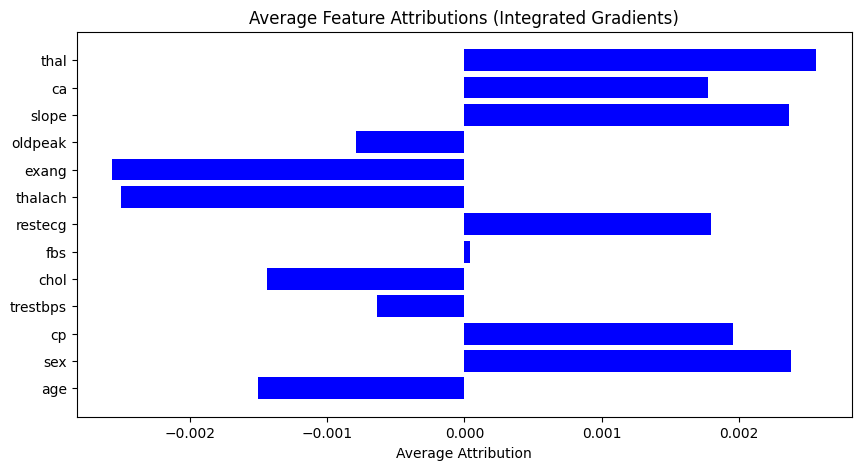

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from captum.attr import IntegratedGradients
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Load and preprocess the UCI Heart Disease dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Replace missing values with NaN and load the dataset
df = pd.read_csv(url, header=None, names=column_names, na_values="?")
df = df.dropna()

# Separate features and target
X = df.drop('target', axis=1)
y = df['target'].apply(lambda x: 1 if x > 0 else 0)  # Binary classification: 1 for disease, 0 for no disease

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for testing data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Step 2: Define a simple neural network model
class HeartDiseaseModel(nn.Module):
    def __init__(self):
        super(HeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(13, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 2)  # Output layer for binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = HeartDiseaseModel()
model.eval()

# Step 3: Train the model (if needed) or load a pre-trained model
# Assuming you have trained the model, load it
# model.load_state_dict(torch.load('heart_disease_model.pth'))

# Step 4: Initialize Integrated Gradients and compute attributions for each feature across all test samples
ig = IntegratedGradients(model)

# Initialize a tensor to hold the attributions for all features
all_attributions = torch.zeros((len(X_test_tensor), X_test_tensor.shape[1]))

# Iterate over the test dataset and compute attributions
for i, (input_data, target_label) in enumerate(test_loader):
    baseline = torch.zeros_like(input_data)
    attributions, delta = ig.attribute(input_data, baseline, target=target_label, return_convergence_delta=True)
    all_attributions[i] = attributions.squeeze()

# Step 5: Calculate the average attribution for each feature across the test set
mean_attributions = all_attributions.mean(dim=0).cpu().numpy()

# Step 6: Visualize the feature interpretability values (mean attributions)
def visualize_mean_attr(attr, feature_names):
    plt.figure(figsize=(10, 5))
    plt.barh(feature_names, attr, color='blue')
    plt.xlabel('Average Attribution')
    plt.title('Average Feature Attributions (Integrated Gradients)')
    plt.show()

# Define the feature names
feature_names = X.columns

visualize_mean_attr(mean_attributions, feature_names)


Using Meta's captum

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from captum.attr import IntegratedGradients
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Load and preprocess the UCI Heart Disease dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Replace missing values with NaN and load the dataset
df = pd.read_csv(url, header=None, names=column_names, na_values="?")
df = df.dropna()

# Separate features and target
X = df.drop('target', axis=1)
y = df['target'].apply(lambda x: 1 if x > 0 else 0)  # Binary classification: 1 for disease, 0 for no disease

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for testing data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Step 2: Define a simple neural network model
class HeartDiseaseModel(nn.Module):
    def __init__(self):
        super(HeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(13, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 2)  # Output layer for binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = HeartDiseaseModel()
model.eval()

# Step 3: Train the model (if needed) or load a pre-trained model
# Assuming you have trained the model, load it
# model.load_state_dict(torch.load('heart_disease_model.pth'))

# Step 4: Initialize Integrated Gradients and compute attributions for each feature across all test samples
ig = IntegratedGradients(model)

# Initialize a tensor to hold the attributions for all features
all_attributions = torch.zeros((len(X_test_tensor), X_test_tensor.shape[1]))

# Iterate over the test dataset and compute attributions
for i, (input_data, target_label) in enumerate(test_loader):
    baseline = torch.zeros_like(input_data)
    attributions, delta = ig.attribute(input_data, baseline, target=target_label, return_convergence_delta=True)
    all_attributions[i] = attributions.squeeze()

# Step 5: Calculate the average attribution for each feature across the test set
mean_attributions = all_attributions.mean(dim=0).cpu().numpy()

# Step 6: Create a table with feature names and their corresponding average attributions
feature_names = X.columns
attributions_df = pd.DataFrame({
    'Feature': feature_names,
    'Average Attribution': mean_attributions
})

# Display the table
print(attributions_df)


     Feature  Average Attribution
0        age            -0.003673
1        sex            -0.000434
2         cp            -0.004202
3   trestbps            -0.002589
4       chol            -0.000223
5        fbs            -0.001079
6    restecg            -0.001987
7    thalach            -0.004438
8      exang             0.003228
9    oldpeak            -0.010129
10     slope            -0.004840
11        ca             0.001944
12      thal            -0.008827


100%|██████████| 170498071/170498071 [00:02<00:00, 76147807.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


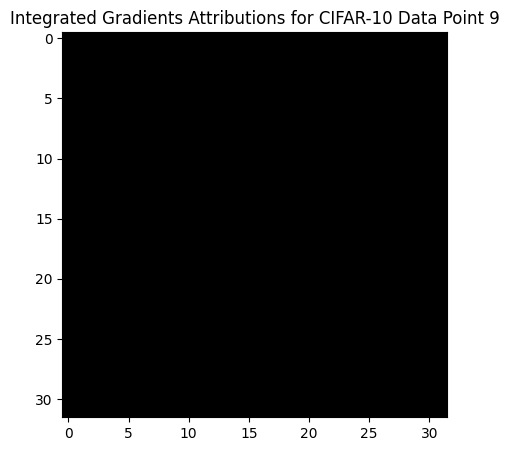

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=False)

# Step 2: Define a simple CNN model for CIFAR-10
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = CIFAR10Model()
model.eval()

# Step 3: Train the model (if needed) or load a pre-trained model
# For simplicity, assume we train the model here
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop (skipped for brevity, assuming you load a trained model)
# Uncomment and modify this part if you need to train the model
# for epoch in range(10):
#     model.train()
#     for data, target in DataLoader(cifar10_train, batch_size=64, shuffle=True):
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()

# Step 4: Select a data point with index 9 and compute attributions
input_data, target_label = next(iter(test_loader))
input_data = input_data[0].unsqueeze(0)  # Select the 9th data point
target_label = target_label[0].unsqueeze(0)

# Baseline (zero tensor)
baseline = torch.zeros_like(input_data)

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions
attributions, delta = ig.attribute(input_data, baseline, target=target_label, return_convergence_delta=True)

# Convert attributions to numpy for visualization
attributions = attributions.squeeze().cpu().detach().numpy()

# Step 5: Visualize the attributions
def visualize_attr(attr):
    plt.figure(figsize=(10, 5))
    plt.imshow(attr.transpose(1, 2, 0))  # Transpose to match image dimensions
    plt.title('Integrated Gradients Attributions for CIFAR-10 Data Point 9')
    plt.show()

visualize_attr(attributions)
